<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v4: Weight visualisation during learning
This is a new attempt at visualising weight changes during learning, now that I have a better understanding of TensorFlow's auto-graph.

Focus of this notebook:
* generating heatmap images of gradients over time of learning.

Sample training domains:

---


* Deep Learning Specialization C2W2A1 experiments with weight initialisation, against a simple 2D binary classification problem.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit

## Useful tools

In [2]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

class LessVerboseEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, display_interval=None, display_total=10):
        super(LessVerboseEpochLogger, self).__init__()
        self.display_interval = display_interval
        self.display_total = display_total

    def set_params(self, params):
        self.epoch_count = params['epochs']
        if self.display_interval == None:
          self.display_interval = math.floor(self.epoch_count / self.display_total)

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch + 1) % self.display_interval == 0) or epoch == self.epoch_count-1:
            print(f'Epoch {epoch + 1:5d}:', end=' ')
            for key, value in logs.items():
                print(f'{key}: {value:.4f}', end='  ')
            print()

## Baseline: Simple model without visualisations
Actually, we're going to create a setup with few slightly different training regimes corresponding to the experiments from the coursework.


In [3]:
def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


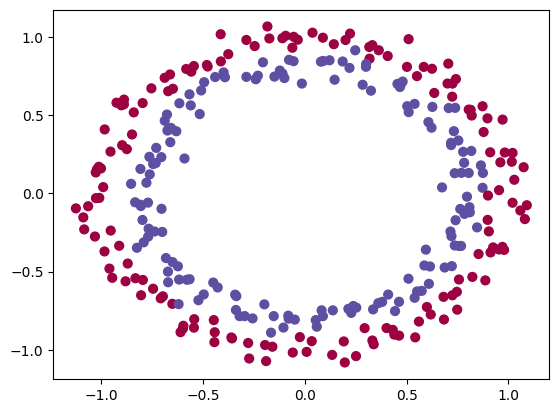

In [4]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [ ]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=15000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch  1500: loss: 0.2160  
Epoch  3000: loss: 0.0713  
Epoch  4500: loss: 0.0347  
Epoch  6000: loss: 0.0191  
Epoch  7500: loss: 0.0125  
Epoch  9000: loss: 0.0094  
Epoch 10500: loss: 0.0078  
Epoch 12000: loss: 0.0070  
Epoch 13500: loss: 0.0065  
Epoch 15000: loss: 0.0063  
Total training time: 84.76 secs


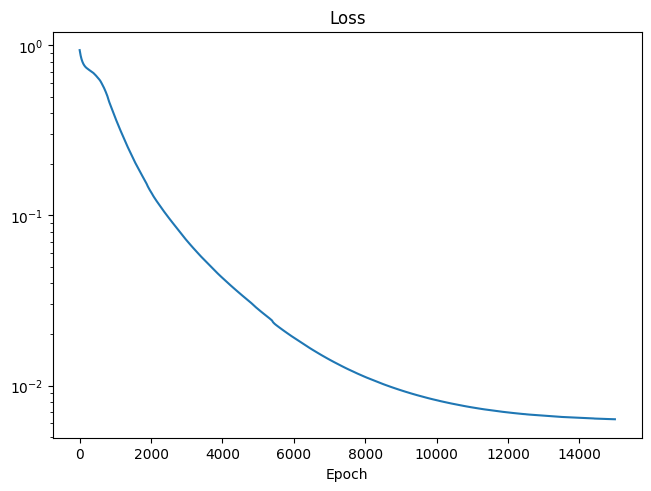

In [ ]:
plot_fit(history)

## Quick Win: Weight Histogram
Let's create quick'n'dirty function for visualising the current weights, in the form of a histogram.

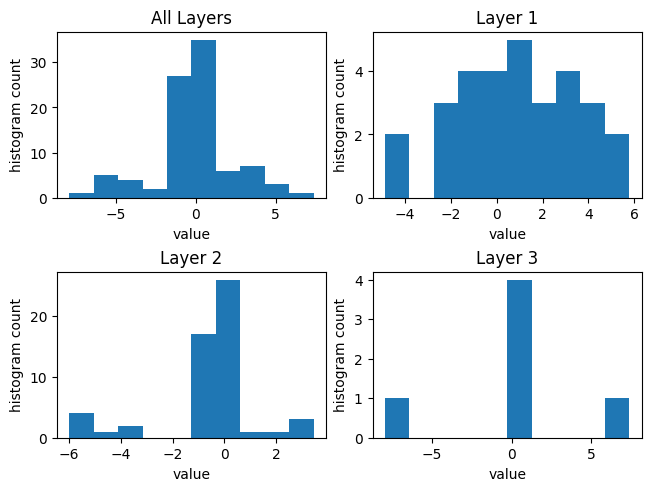

In [ ]:
def plot_weights(model):
  """
  model - the model
  """

  # collect all variables across the entire model into a single flattened array
  all_variables = []
  for layer in model.layers:
    for weight in layer.weights:
      all_variables = np.append(all_variables, weight.numpy().flatten())

  L = len(model.layers)
  plots_tot = L+1
  plots_cols = math.floor(math.sqrt(plots_tot))
  plots_rows = math.ceil(plots_tot / plots_cols)

  plt.figure(layout='constrained')

  plt.subplot(plots_rows, plots_cols, 1)
  plt.title("All Layers")
  plt.hist(all_variables)
  plt.xlabel("value")
  plt.ylabel("histogram count")

  for l in range(L):
    variables = []
    for weight in model.layers[l].weights:
      variables = np.append(variables, weight.numpy().flatten())
    plt.subplot(plots_rows, plots_cols, l+2)
    plt.title(f"Layer {l+1}")
    plt.hist(variables)
    plt.xlabel("value")
    plt.ylabel("histogram count")
  plt.show()
plot_weights(model)

## Gradient heatmap
There's two things to do here:
1. Collect gradient information during training
2. Plot it in various ways.

TensorFlow doesn't seem to provide very good means for capturing gradient information during training. It's standard Logger interface doesn't get passed that information. Instead, an Optimizer-wrapper seems the only solution.

Furthermore, while using a `tf.TensorArray` seems like a sensible option, it seems to be optimized for use _within_ a `@tf.function` and can't be initialised outside like a `tf.Variable`. So I've so found the only solution is to store everything as a matrix inside a `tf.Variable`, with rows containing a flattened copy of all the necessary information, and successive rows representing successive iterations. This particular implementation adds a bit of a delay to execution time. The problem is that it doesn't know the total number of iterations up front, so we'll get a lot of re-allocation cost. I suspect a better approach is to combine a Callback with the optimizer wrapper, because the Callback gets enough information to pre-allocate the memory.

In [14]:
# Note the basic delegation implementation of optimizer was provided by ChatGPT and seems to be working
class LoggingOptimizerWrapper(tf.keras.optimizers.Optimizer):
  def __init__(self, optimizer='adam', name="LoggingOptimizerWrapper", **kwargs):
    """
    Args:
      delegate: real optimizer to wrap. String (name of optimizer) or optimizer instance. See `tf.keras.optimizers`.
    """
    if isinstance(optimizer, str):
      optimizer = tf.keras.optimizers.get(optimizer)
    super(LoggingOptimizerWrapper, self).__init__(f"{name}:{optimizer.name}", **kwargs)
    self._delegate = optimizer

    # the shape=None thing here tells the Variable to accept changing shapes
    # but it has the sideeffect that self._gradients_by_step.shape always returns None while executing.
    self._gradients_by_step = tf.Variable(np.zeros((0,0)), shape=tf.TensorShape(None), dtype=tf.float32)
    self._initialised = tf.Variable(0)

  def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
    """
      Args:
        grads_and_vars: List of `(gradient, variable)` pairs.
    """
    grads_and_vars = list(grads_and_vars)
    grads, _ = zip(*grads_and_vars)

    # concatenate all gradient tuples into a single vector
    flattened_grads = tf.zeros(shape=(1,0))
    for grad in grads:
      flattened_grads = tf.concat([flattened_grads, tf.reshape(grad, [1, -1])], axis=1)

    # append to list (or just set list on first iteration)
    tf.cond(self._initialised < 1,
            lambda: self._gradients_by_step.assign(flattened_grads),
            lambda: self._gradients_by_step.assign(tf.concat([self._gradients_by_step, flattened_grads], axis=0)))
    self._initialised.assign(1)

    # delegate for default behaviour
    return self._delegate.apply_gradients(grads_and_vars, name, experimental_aggregate_gradients)

  # delegate all other methods and properties

  def build(self, var_list):
    super().build(var_list)

  def _create_slots(self, var_list):
    self._delegate._create_slots(var_list)

  def _create_hypers(self):
    self._delegate._create_hypers()

  def _prepare_local(self, var_device, var_dtype, apply_state):
    return self._delegate._prepare_local(var_device, var_dtype, apply_state)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    return self._delegate._resource_apply_dense(grad, var, apply_state)

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    return self._delegate._resource_apply_sparse(grad, var, indices, apply_state)

  def get_config(self):
    base_config = super(LoggingOptimizerWrapper, self).get_config()
    return {**base_config, "_delegate": tf.keras.optimizers.serialize(self._delegate)}

  @classmethod
  def from_config(cls, config, custom_objects=None):
    delegate_config = config.pop('_delegate')
    delegate = tf.keras.optimizers.deserialize(delegate_config, custom_objects=custom_objects)
    return cls(delegate, **config)

  def _serialize_hyperparameter(self, hyperparameter):
    return self._delegate._serialize_hyperparameter(hyperparameter)

  def get_updates(self, loss, params):
    return self._delegate.get_updates(loss, params)

  def get_weights(self):
    return self._delegate.get_weights()

  def set_weights(self, weights):
    self._delegate.set_weights(weights)

  def variables(self):
    return self._delegate.variables()

  def get_slot(self, var, name):
    return self._delegate.get_slot(var, name)

  def get_slot_names(self):
    return self._delegate.get_slot_names()

model = binary_classification_model('he_normal')
#model.compile(optimizer=LoggingOptimizerWrapper(tf.keras.optimizers.Adam()), loss='binary_crossentropy')
loggingOptimizer = LoggingOptimizerWrapper()
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=4, batch_size=train_X.shape[0])
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")

Epoch 1/4
1/1 [==============================] - 1s 700ms/step - loss: 0.6929
Epoch 2/4
1/1 [==============================] - 0s 9ms/step - loss: 0.6926
Epoch 3/4
1/1 [==============================] - 0s 8ms/step - loss: 0.6922
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.6919
gradient_history: (4, 91)


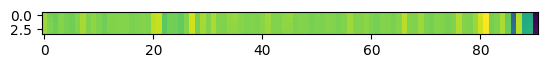

In [15]:
plt.imshow(gradient_history)

In [16]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
loggingOptimizer = LoggingOptimizerWrapper()
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=5000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch   500: loss: 0.4664  
Epoch  1000: loss: 0.1391  
Epoch  1500: loss: 0.0696  
Epoch  2000: loss: 0.0469  
Epoch  2500: loss: 0.0301  
Epoch  3000: loss: 0.0229  
Epoch  3500: loss: 0.0173  
Epoch  4000: loss: 0.0132  
Epoch  4500: loss: 0.0103  
Epoch  5000: loss: 0.0084  
gradient_history: (5000, 91)
Total training time: 18.03 secs


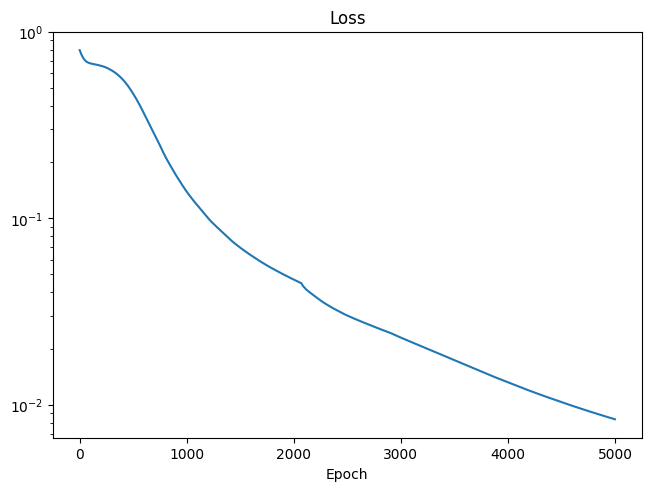

In [17]:
plot_fit(history)

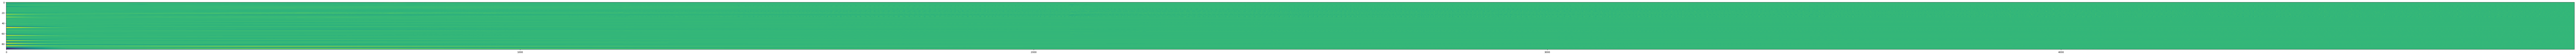

In [31]:
plt.figure(figsize = (200,500))
plt.imshow(gradient_history.T)

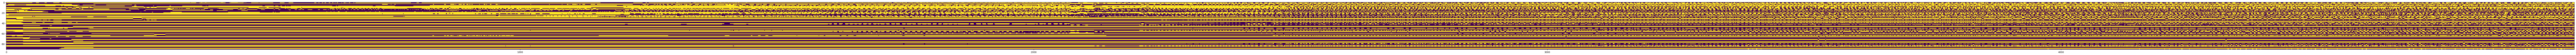

In [27]:
plt.figure(figsize = (200,500))
plt.imshow(np.sign(gradient_history.T))

In [32]:
gradient_history.shape

(5000, 91)

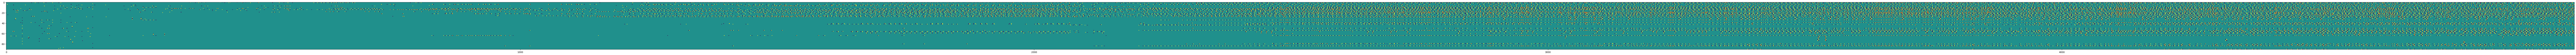

In [33]:
plt.figure(figsize = (200,500))
plt.imshow((np.sign(gradient_history[2:5000,:]) - np.sign(gradient_history[1:4999,:])).T)

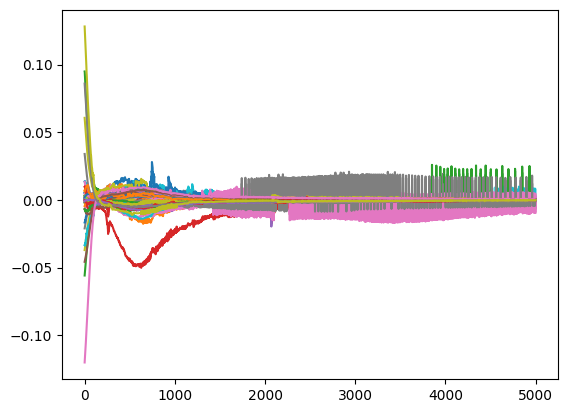

In [26]:
plt.plot(gradient_history[:,1:50])
